# Implementing a GPT model from Scratch To Generate Text

This section covers:

- Coding a GPT-like large language model (LLM) that can be trained to generate human-like text.

- Normalizing layer activations to stabilize neural network training

- Adding shortcut connections in deep neural networks to train models more effectively.

- Implementing transformer blocks to create GPT models of various sizes.

- Computing the number of parameters and storage requirements of GPT models.

In [2]:
from importlib.metadata import version

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.10.6
torch version: 2.0.1
tiktoken version: 0.11.0


![Alt text](../../assests/figure41.png)

## Coding an LLM architecture

LLMs, such as GPT (Generative Pretrained Transformer), are large deep neural network architectures designed to generate new text one word (or token) at a time. 

![Alt text](../../assests/figure42.png)

- We've covered `Input tokenization and embedding`, `masked multi-head attention` module.

- This section focuses on implementing the core structure of the GPT model, including its transformer blocks.
- Therefore, these LLMs are often referred to as `"decoder-like"` LLMs
- Language models are Unsupervised Multitask Learners.
- We are scaling up to the size of a small GPT-2 model, specifically the smallest version with `124` million parameters.
- In the context of deep learning and LLMs like GPT, the term "parameters" refers to the trainable weights of the model. These weights are essentially the internal variables of the model that are adjusted and optimized during the training process to minimize a specific loss function. This optimization allows the model to learn from the training data.
- Compared to conventional deep learning models, LLMs are larger, mainly due to their vast number of parameters, not the amount of code.

- Configuration details for the `124 million` parameter GPT-2 model include:

In [3]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

We use short variable names to avoid long lines of code later
- `"vocab_size"` indicates a vocabulary size of `50,257` words, supported by the `BPE` tokenizer discussed in Chapter 2.

- `"context_length"` represents the model's maximum input token count, as enabled by positional embeddings covered in Chapter 2

- `"emb_dim"` is the embedding size for token inputs, converting each input token into a `768`-dimensional vector

- `"n_heads"` is the number of attention heads in the `multi-head attention` mechanism implemented in Chapter 3
  
- `"n_layers"` is the number of transformer blocks within the model, which we'll implement in upcoming sections

- `"drop_rate"` is the dropout mechanism's intensity, discussed in Chapter 3; `0.1` means dropping `10%` of hidden units during training to mitigate overfitting

- `"qkv_bias"` decides if the Linear layers in the multi-head attention mechanism (from Chapter 3) should include a bias vector when computing `query (Q)`, `key (K)`, and `value (V)` tensors; we'll disable this option, which is standard practice in modern LLMs; however, we'll revisit this later when loading pretrained GPT-2 weights from OpenAI into our reimplementation in chapter 5



Using the configuration above, we will start this section by implementing a `GPT placeholder` architecture (`DummyGPTModel`) in this section, as shown in the figure below. This will provide us with a big-picture view of how everything fits together and what other components we need to code in the upcoming sections to assemble the full GPT model architecture.


![Alt text](../../assests/figure43.png)

In [7]:
# A placeholder GPT model architecture class

import torch
import torch.nn as nn 


class DummyGPTModel(nn.Module):
    def __init__(self, config: dict):
        super().__init__()
        self.tok_emb = nn.Embedding(config["vocab_size"], config["emb_dim"])
        self.pos_emb = nn.Embedding(config["context_length"], config["emb_dim"])
        self.drop_emb = nn.Dropout(config["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(config) for _ in range(config["n_layers"])]
        )
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(config["emb_dim"])
        self.out_head = nn.Linear(
            config["emb_dim"], config["vocab_size"], bias=False
        )
        
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    
    

class DummyTransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        # A simple placeholder
        
    def forward(self, x):
        # This block does nothing and just returns its input
        return x
    

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface
        
    def forward(self, x):
        # This layer does nothing and just returns its input
        return x

The `DummyGPTModel` class above defines a simplified version of a GPT-like model using PyTorch's neural network module (nn.Module). The model architecture in the `DummyGPTModel` class consists of token and positional embeddings, dropout, a series of transformer blocks `(DummyTransformerBlock)`, a final layer normalization `(DummyLayerNorm)`, and a linear output layer `(out_head)`. 

- The configuration is passed in via a Python dictionary, for instance, the `GPT_CONFIG_124M` dictionary we created earlier.

- The `forward` method describes the data flow through the model; it computes `token` and `positional` embeddings for the input indices, applies `dropout`, processes the data through the `transformer` blocks, applies normalization, and finally produces logits with the linear output layer.

- The code above is already functional, as we will see later in this section after we prepare the input layer. However, the placeholders `(DummyLayerNorm and DummyTransformerBlock)` for the transformer block and layer normalization, which we will develop in later sections.

![Alt text](../../assests/figure44.png)

Next, we will prepare the input data and initialize a new GPT model to illustrate its usage. 


- To implement the step in the figure above, we tokenize a batch consisting of two text inputs for the GPT model using the `tiktoken` tokenizer introduced in chap.2

In [8]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

text1 = "Every effort moves you"
text2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(text1)))
batch.append(torch.tensor(tokenizer.encode(text2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [10]:
batch.shape

torch.Size([2, 4])

- The output above are the resulting token IDs for the two texts. The first row corresponds to the first text, and the second row corresponds to the second text.

- Next, we initialize a new `124 million` parameter `DummyGPTModel` instance and feed it the tokenized `batch`:

In [9]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


- The model outputs above, are commonly referred to as logits.

- The output tensor has two rows corresponding to the two text samples. Each text sample consists of 4 tokens; each token is a `50,257`-dimensional vector, which matches the size of the tokenizer's vocabulary.

- The embedding has `50,257` dimensions because each of these dimensions refers to a unique token in the vocabulary. 

In [13]:
model

DummyGPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): DummyTransformerBlock()
    (1): DummyTransformerBlock()
    (2): DummyTransformerBlock()
    (3): DummyTransformerBlock()
    (4): DummyTransformerBlock()
    (5): DummyTransformerBlock()
    (6): DummyTransformerBlock()
    (7): DummyTransformerBlock()
    (8): DummyTransformerBlock()
    (9): DummyTransformerBlock()
    (10): DummyTransformerBlock()
    (11): DummyTransformerBlock()
  )
  (final_norm): DummyLayerNorm()
  (out_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [20]:
# Access model parameters
for name, param in model.named_parameters():
    print(f"Layer: {name}, Shape: {param.shape}")
    print(f"Weights: \n{param.data}") # .data to get the tensor values

Layer: tok_emb.weight, Shape: torch.Size([50257, 768])
Weights: 
tensor([[ 3.3737e-01, -1.7778e-01, -3.0353e-01,  ..., -3.1813e-01,
         -1.3936e+00,  5.2262e-01],
        [ 2.5787e-01,  3.4197e-01, -8.1678e-01,  ..., -4.0981e-01,
          4.9785e-01, -3.7207e-01],
        [ 7.9574e-01,  5.3501e-01,  9.4275e-01,  ..., -1.0749e+00,
          9.5492e-02, -1.4138e+00],
        ...,
        [-7.1278e-01, -5.0190e-01,  1.4119e+00,  ..., -1.4979e-01,
         -4.8977e-01, -1.0620e+00],
        [ 2.0646e+00,  1.1190e+00,  3.8486e-01,  ..., -7.2015e-01,
         -5.5703e-01,  9.8639e-01],
        [ 1.1364e-03, -7.5320e-01, -1.7924e-01,  ..., -3.2443e-01,
          2.6055e-01,  5.8885e-01]])
Layer: pos_emb.weight, Shape: torch.Size([1024, 768])
Weights: 
tensor([[ 0.8769,  0.2550,  0.8441,  ..., -1.0354,  1.3085,  1.7957],
        [-1.0029,  0.0995,  1.2459,  ...,  1.5453, -0.1126, -1.5197],
        [ 1.3317,  0.7561,  0.9077,  ...,  0.0830,  1.8336, -2.2225],
        ...,
        [-0.1055

## Normalizing activations with layer normalization

- Training deep neural networks with many layers can sometimes prove challenging due to issues like `vanishing` or `exploding` gradients. These issues lead to unstable training dynamics and make it difficult for the network to effectively adjust its weights, which means the learning process struggles to find a set of parameters (weights) for the neural network that minimizes the `loss function`. In other words, the network has difficulty learning the underlying patterns in the data to a degree that would allow it to make accurate predictions or decisions. 


- We will implement a  `layer normalization` to improve the stability and efficiency of neural network training.
- The main idea behind `layer normalization` is to adjust the activations (outputs) of a neural network layer to have a mean of `0` and a variance of `1`, also know as `unit variance`.
- This adjustment speeds up the convergence to effective weights and ensures consistent, reliable training. 
- Layer normalization is applied both before and after the multi-head attention module within the transformer block, which we will implement later.
- It's also applied before the final output layer.


Here is a visual overview of how layer normalization functions.

![Alt text](../../assests/figure45.png)

- Let's see how layer normalization works by passing a small input sample through a simple neural network layer:

In [25]:
torch.manual_seed(123)

# create 2 training examples with 5 dimensions (features) each
batch_example = torch.randn(2, 5)

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


- The first row of the output above lists the layer outputs for the first input and the second row lists the layer outputs for the second row:

- The neural network layer above consists of a `Linear` layer followed by a non-linear activation function, `ReLU` (short for Rectified Linear Unit), which is a standard activation function in neural networks. 

- `ReLU` simply thresholds negative inputs to `0`, ensuring that a layer outputs only positive values, which explains why the resulting layer output does not contain any negative values.

In [26]:
print(out.shape)

torch.Size([2, 6])


Let's compute the mean and variance for each of the 2 inputs above:

In [23]:
mean = out.mean(dim=1, keepdim=True)
var = out.var(dim=1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [29]:
mean.shape, var.shape

(torch.Size([2, 1]), torch.Size([2, 1]))

- The first row in the `mean` tesnor contains the `mean` value for the first input row, and the second output row contains the `mean` for the second input row.

- Using `keepdim=True` in operations like mean or variance calculation ensures that the output tensor retains the same number of dimensions as the input tensor, even though the operation reduces the tensor along the dimension specified via `dim`. For instance, without `Keepdim=True`, the returned mean tensor would be a 2-dimensional vector of `[0.1324,
0.2170]` instead of a 2×1-dimensional matrix `[[0.1324], [0.2170]]`.

- The `dim` parameter specifies the dimension along which the calculation of the statistic (here, mean and variance) should be performed in a tensor.

![Alt text](../../assests/figure46.png)


From the figure above, for a `2D` tensor (like a matrix), using `dim=-1` for operations such as mean and variance calculation is the same as using `dim=1`. This is beacuase `-1` refers to the tensor's last dimension, which corresponds to the columns in a `2D` tensor. 

- Later, when adding layer normalization to the GPT model, which produces `3D` tensors with shape `[batch_size, num_tokens, embedding_size]`, we can still use `dim=-1` for normalization across the last dimension, avoiding a change from `dim=1` to `dim=2`.

- Let us apply layer normalization to the layer outputs we obtained earlier. The operation consists of substracting the mean and dividing by the `square-root` of the variance (also known as `standard deviation`). This centers the inputs to have a mean of `0` and a variance of `1` across the column (feature) dimension:

In [32]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[2.9802e-08],
        [3.9736e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


- The normalized layer outputs above contain negative values, have zero mean and a variance of 1.

- To improve readability, we can also turn off the scientific notation when printing tensor values by setting `sci_mode` to False:

In [33]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


- Above we normalized the features of each input.
- Now, using the same idea, we can implement a `LayerNorm` class:

In [34]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        
    def forward(self, x: torch.Tensor):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

- This specific implementation of `layer Normalization` operates on the last dimension of the input tensor `x`, which represents the embedding dimension `(emb_dim)`. The variable `eps` is a small constant `(epsilon)` added to the variance to prevent division by zero during normalization.

**Scale and shift**

- Note that in addition to performing the normalization by subtracting the mean and dividing by the variance, we added two trainable parameters, a `scale` and a `shift` parameter.

- The initial `scale` (multiplying by 1) and `shift` (adding 0) values don't have any effect; however, `scale` and `shift` are trainable parameters that the LLM automatically adjusts during training if it is determined that doing so would improve the model's performance on its training task.

- This allows the model to learn appropriate scaling and shifting that best suit the data it is processing.

- Note that we also add a smaller value `(eps)` before computing the square-root of the variance; this is to avoid division-by-zero errors if the variance is `0`.

**BIASED VARIANCE**

- In the variance calculation above, setting `unbiased=False` means using the formula:

$$\sigma^2 = \frac{1}{n} \sum_{i=1}^{n} (x_i - \mu)^2$$

to compute the variance, where $n$ is the sample size (here, the number of features or columns). This formula does not include Bessel's correction (which uses $n-1$ in the denominator), thus providing a **biased estimate** of the population variance.

- For LLMs, where the embedding dimension `n` is very large, the difference between using `n` and `n-1` is negligible.

- However, `GPT-2` was trained with a biased variance in the normalization layers, which is why we also adopted this setting for compatibility reasons with the pretrained weights that we will load in later section.

- Let's now try the LayerNorm module in practice and apply it to the batch input:

In [35]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


![Alt text](../../assests/figure47.png)

**LAYER NORMALIZATION VERSUS BATCH NORMALIZATION**


If you are familiar with batch normalization, a common and traditional normalization method for neural networks, you may wonder how it compares to layer normalization. Unlike batch normalization, which normalizes across the batch dimension, layer normalization normalizes across the feature dimension. LLMs often require significant computational resources, and the available hardware or the specific use case can dictate the batch size during training or inference. Since layer
normalization normalizes each input independently of the batch size, it offers more flexibility and stability in these scenarios. This is particularly beneficial for `distributed training` or when deploying models in environments where resources are constrained.

## Implementing a feed forward network with GELU activations


- In this section, we implement a small neural network submodule that is used as part of the transformer block in LLMs.
- We start with the activation function.
- In deep learning, `ReLU` (Rectified Linear Unit) activation functions are commonly used due to their simplicity and effectiveness in various neural network architecture.
- In LLMs, various other types of activation functions are used beyond the traditional ReLU; two notable examples are `GELU` (Gaussian Error Linear Unit) and `SwiGLU` (Swish-Gated Linear Unit).
- `GELU` and `SwiGLU` are more complex, smooth activation functions incorporating Gaussian and sigmoid-gated linear units, respectively, offering better performance for deep learning models, unlike the simpler, piecewise linear function of `ReLU`.




### **GELU**

The **GELU** (Gaussian Error Linear Unit) activation function is defined as:

$$\text{GELU}(x) = x \cdot \Phi(x)$$

where $\Phi(x)$ is the cumulative distribution function of the standard normal distribution.

It can be approximated by:

$$\text{GELU}(x) \approx 0.5x \left(1 + \tanh\left(\sqrt{\frac{2}{\pi}}(x + 0.044715x^3)\right)\right)$$

**Key property:** It smoothly weights inputs by their value, using a probabilistic approach (rather than a hard gate like ReLU).

In [36]:
# An implementation of the GELU activation function

class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x: torch.Tensor):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

- To get an idea of what this `GELU` function looks like and how it compares to the `ReLU` function, let's plot these functions side by side:

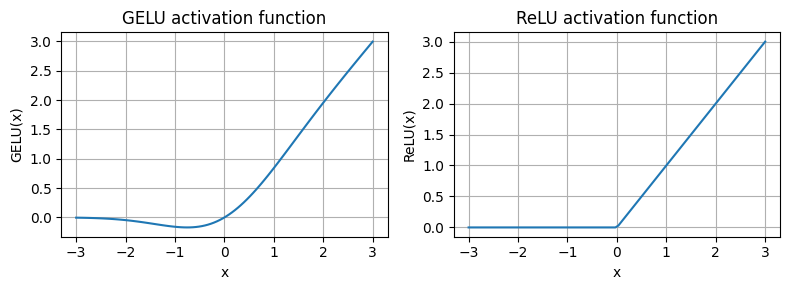

In [42]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

- As seen from the plot above, `ReLU` is a piecewise linear function that outputs the input directly if it is positive; otherwise, it outputs zero.

- `ReLU` has a sharp corner at zero, which can sometimes make optimization harder, especially in networks that are very deep or have complex architectures.

- The smooothness of `GELU` can lead to better optimization properties during training, as it allows for more naunced adjustments to the model's parameters.

- `GELU` is a smooth, non-linear function that approximates `ReLU` but with a non-zero gradient for negative values (except at approximately `-0.75`)

- `GELU` allows for a small, non-zero output for negative values. This means that during the training process, neurons that receive negative input can still contribute to the learning process, albeit to a lesser extent than positive inputs.


- Next, let's implement the small neural network module, `FeedForward`, that we will be using in the `LLM's` transformer block later:

In [43]:
# A feed. forward neural network

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(config["emb_dim"], 4 * config["emb_dim"]),
            GELU(),
            nn.Linear(4 * config["emb_dim"], config["emb_dim"]),
        )
        
    def forward(self, x: torch.Tensor):
        return self.layers(x)

- As seen in the preceding code, the `FeedForward` module is a small neural network consisting of two `Linear` layers and a `GELU` activation function. In the 124 million parameter GPT model, it receives the input batches with tokens that have an embedding size of `768` each via the `GPT_CONFIG_124M` dictionary where `GPT_CONFIG_124M["emb_dim"] = 768`.

In [44]:
print(GPT_CONFIG_124M["emb_dim"])

768


![Alt text](../../assests/figure49.png)

- The above image provides a visual overview of the connections between the layers of the feed forward neural network. It is important to note that this neural network can accommodate variable batch sizes and numbers of tokens in the input. However, the embedding size for each token is determined and fixed when initializing the weights.

In [45]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768) 
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


- from the above output, the shape of the output tensor is the same as that of the input tensor.

The `FeedForward` module we implemented in this section plays a crucial role in enhancing the model's ability to learn from and generalize the data. Although the input and output dimensions of this module are the same, it internally expands the embedding dimension into a higher-dimensional space through the first linear layer as illustrated in the figure below. 

![Alt text](../../assests/figure410.png)

`An illustration of the expansion and contraction of the layer outputs in the feed forward neural
network. First, the inputs expand by a factor of 4 from 768 to 3072 values. Then, the second layer compresses
the 3072 values back into a 768-dimensional representation.`

This expansion is followed by a non-linear `GELU` activation, and then a contraction back to the original dimension with the second linear transformation. Such a design allows for the exploration of a richer representation space.

The uniformity in input and output dimensions simplifies the architecture by enabling the stacking of multiple layers, without the need to adjust dimensions between them, thus making the model more scalable.

![Alt text](../../assests/figure411.png)

## Adding shortcut connections

- Next, let's talk about the concept behind shortcut connections, also called `skip` or `residual` connections

- Originally, shortcut connections were proposed in deep networks for computer vision (residual networks) to mitigate vanishing gradient problems.

- The vanishing gradient problem refers to the issue where gradients (which guide weight updates during training) become progressively smaller as they propagate backward through the layers, making it difficult to effectively train earlier layers.

- A shortcut connection creates an alternative shorter path for the gradient to flow through the network

- This is achieved by adding the output of one layer to the output of a later layer, usually skipping one or more layers in between

- Let's illustrate this idea with a small example network:


![Alt text](../../assests/figure412.png)



### **Shortcut Connection (Skip Connection)**

#### **Intuition**
Shortcut connections skip one or more layers, allowing the gradient to flow directly backwards during training. This mitigates the **vanishing gradient problem** in deep networks, enabling the training of very deep architectures (e.g., ResNet).

#### **Math (ResNet Style)**
For a layer with input $( x )$, the output $( y )$ with a shortcut is:

$$y = F(x, \{W_i\}) + x$$

where $( F(x, {W_i}) )$ is the transformation (e.g., convolutional layers) and $( x )$ is the identity shortcut.

#### **Code Example (PyTorch)**
```python
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        out += residual  # Shortcut connection
        out = self.relu(out)
        return out
```

#### **Why it works**
- **Eases optimization**: The network can learn identity functions easily.
- **Improves gradient flow**: Gradients can propagate directly through shortcuts, avoiding degradation.

In [ ]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])
        
    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


- The code above implements a deep neural network with `5` layers, each consisting of a `Linear` layer and a `GELU` activation function. In the forward pass, we iteratively pass the input through the layers and optionally add the shortcut connections if the `self.use_shortcut` attribute is set to `True`.

The code below computes the loss function, which quantifies how close the model output and a specified target are. Then, when calling `loss.backward()`, PyTorch computes the loss gradient for each layer in the model. We can iterate through the weight parameters via `model.named_parameters()`. 

- Next, we implement a function that computes the gradients in the model's backward pass:

In [48]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])
    
    # Calculate loss based on how close the target and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # Backward pass to calculate the gradients
    loss.backward()
    
    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

Let' use this code to initialize a neural network without `shortcut connections`. Here, each layer will be initialized such that it accepts an example with `3` input values and returns `3` output values. The last layer returns a single output.

In [59]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False,
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


As seen from the output of above, the gradients become smaller as we progress from the last layer `(layers.4)` to the first layer `(layers.0)`, which is a phenomenon called the `vanishing gradient` problem.

- Next, we print the gradient values with shortcut connections:

In [58]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
torch.autograd.set_detect_anomaly(True)
print_gradients(model_with_shortcut, sample_input)

/Users/user/Projects/Building-LLMs-from-scratch/venv/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning: Error detected in AddmmBackward0. Traceback of forward call that caused the error:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/user/Projects/Building-LLMs-from-scratch/venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/user/Projects/Building-LLMs-from-scratch/venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/user/Projects/Building-LLMs-from-scratch/venv/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/Users/user/Projects/Building-LLMs-from-scratch/venv/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 211, in start
    self.asyncio_loop.run_forever()
  File "/opt/hom

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [1, 3]], which is output 0 of AddBackward0, is at version 4; expected version 3 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!